In [1]:
pretty = True
highres = True

%matplotlib inline
if highres:
    %config InlineBackend.figure_format = 'retina'
else:
    %config InlineBackend.figure_format = 'png'

#rcParams["figure.dpi"]=300

import sys

pypsapath = "C:/dev/py/PyPSA/"
datapath = "../../data/"

if sys.path[0] != pypsapath:
    sys.path.insert(0,pypsapath)

%load_ext autoreload
%autoreload 2

In [2]:
import pypsa
import numpy as np
import pandas as pd
import os
import itertools

import matplotlib.pyplot as plt
import matplotlib.ticker
import pathlib

from IPython.display import Markdown, display
printm = lambda s: display(Markdown(s))

In [4]:
csv_folder_name = datapath + "raw/scigrid-with-load-gen-trafos/"

if not pathlib.Path(csv_folder_name).exists():
    raise Warning("SciGRID data not found. Make sure that you have downloaded the dataset corretly, and that the path is set correctly in this script.")

In [5]:
network = pypsa.Network(import_name=csv_folder_name)
network.generators.carrier = network.generators.source

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, generators, lines, loads, storage_units, transformers


In [6]:
bus_names = list(network.buses.index)
bus_names_220_suffix = [n for n in bus_names if n[-6:]=="_220kV"]
suffix_removed = [n[:-6] for n in bus_names_220_suffix]
pairs = list(zip(suffix_removed, bus_names_220_suffix))

pd.set_option('display.max_columns', None)
pd.reset_option('display.max_rows')


generator_buses = network.generators.bus.unique()

In [7]:
n = len(generator_buses)
m = len(network.lines)

# N:
new_nodes = sorted(list(generator_buses))


def node_index(bus_name):
    if bus_name in suffix_removed:
        return node_index(bus_name + "_220kV")
    return new_nodes.index(bus_name)

# L:
new_lines = [(node_index(a),node_index(b)) for i,a,b in network.lines[['bus0','bus1']].itertuples()]

operating_voltage_lines = network.lines.voltage.values

In [8]:
#network.generators_t.p_max_pu.describe()
gen_capacity = network.generators.p_nom[network.generators_t.p_max_pu.columns]

carriers = network.generators.carrier.unique()

saturation_per_gen = pd.DataFrame((network.generators_t.p_max_pu > .99).sum()/len(network.generators_t.p_max_pu), columns=['saturation'])
saturation_per_gen['carrier'] = network.generators.carrier[saturation_per_gen.index]

saturation_per_gen.groupby('carrier').mean()

,saturation
carrier,
Solar,0.000004
Wind Offshore,0.285228
Wind Onshore,0.010647


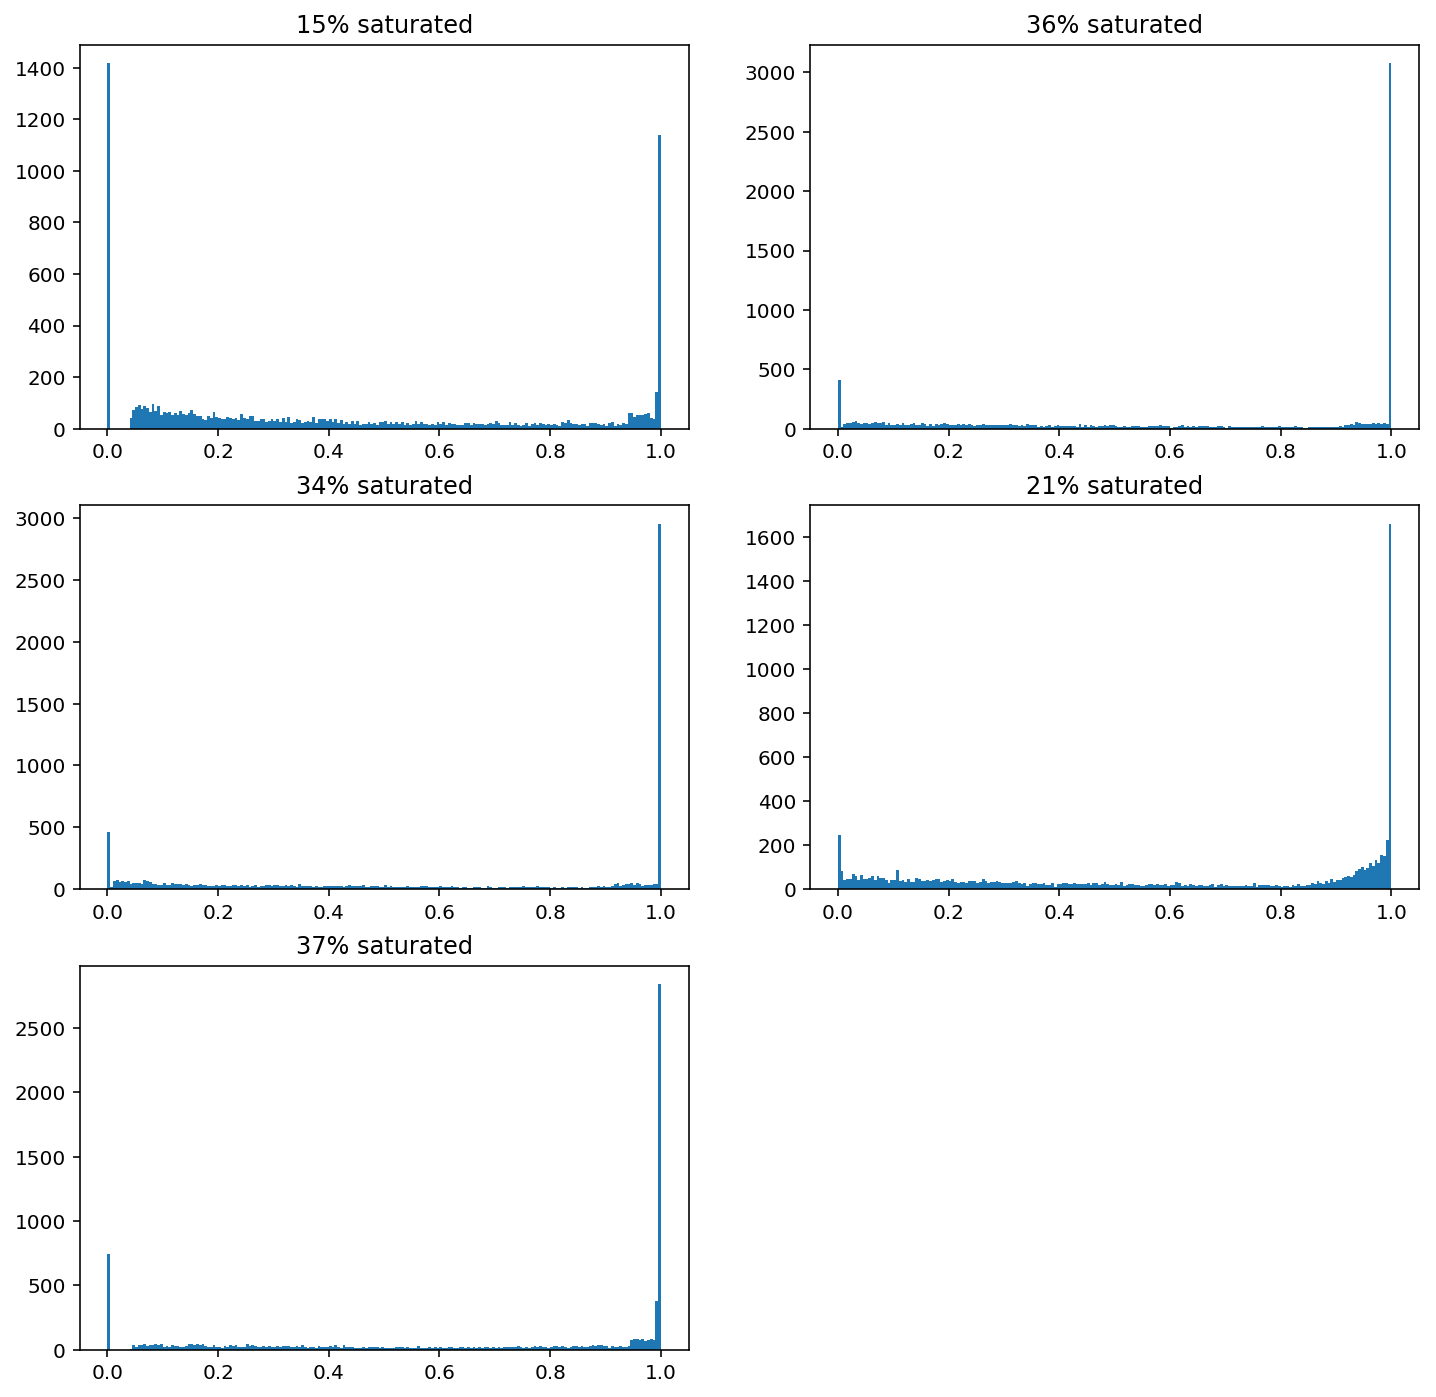

In [9]:
offshore_saturation = network.generators_t.p_max_pu.loc[:,saturation_per_gen.carrier == 'Wind Offshore']

fig = plt.figure(figsize=(12,12))

for i,(x,y) in enumerate(offshore_saturation.iteritems()):
    plt.subplot(3,2,i+1)
    plt.hist(y,bins=200)
    plt.title("{:.0%} saturated".format((y > .99).sum()/len(y)))
    

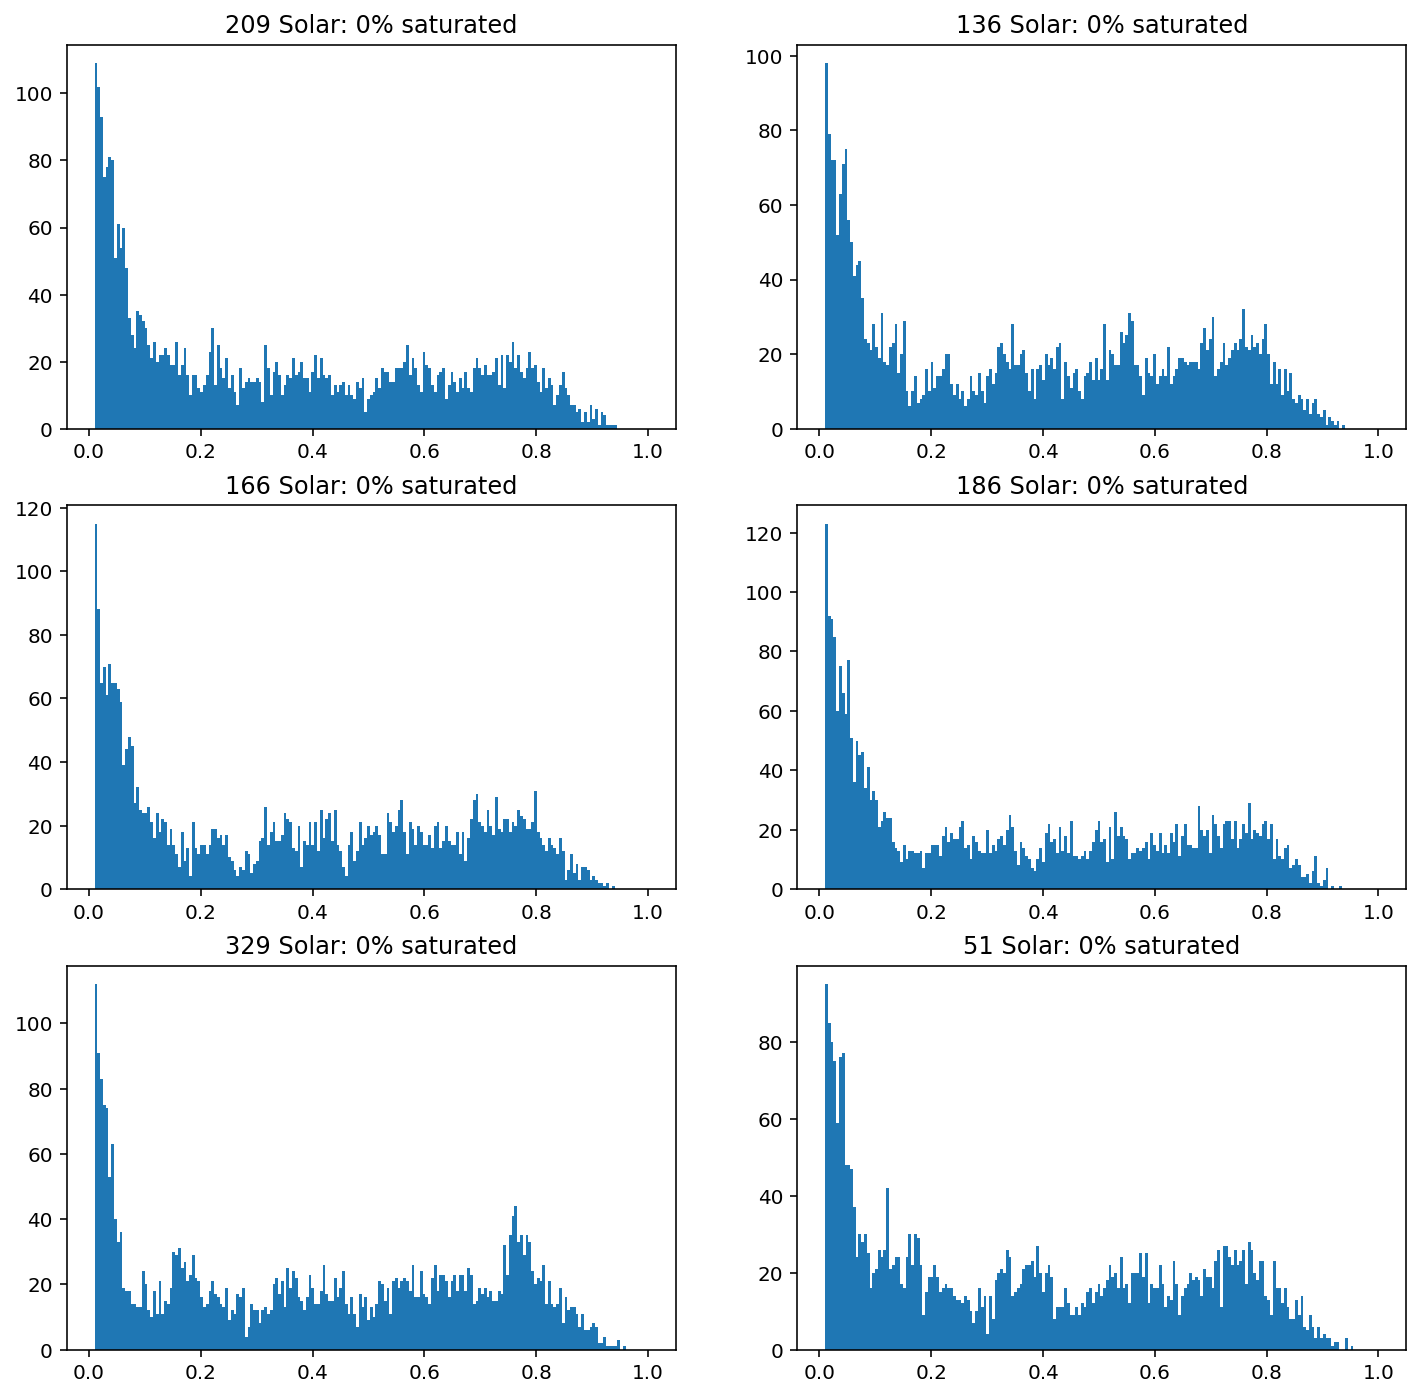

In [10]:
solar_saturation = network.generators_t.p_max_pu.loc[:,saturation_per_gen.carrier == 'Solar']

fig = plt.figure(figsize=(12,12))

solar_selection = np.random.choice(solar_saturation.columns, size=6)

for i,(x,y) in enumerate(solar_saturation[solar_selection].iteritems()):
    plt.subplot(3,2,i+1)
    plt.hist(y,bins=np.linspace(0.01,1,num=200))
    plt.title("{0}: {1:.0%} saturated".format(x,(y > .99).sum()/len(y)))

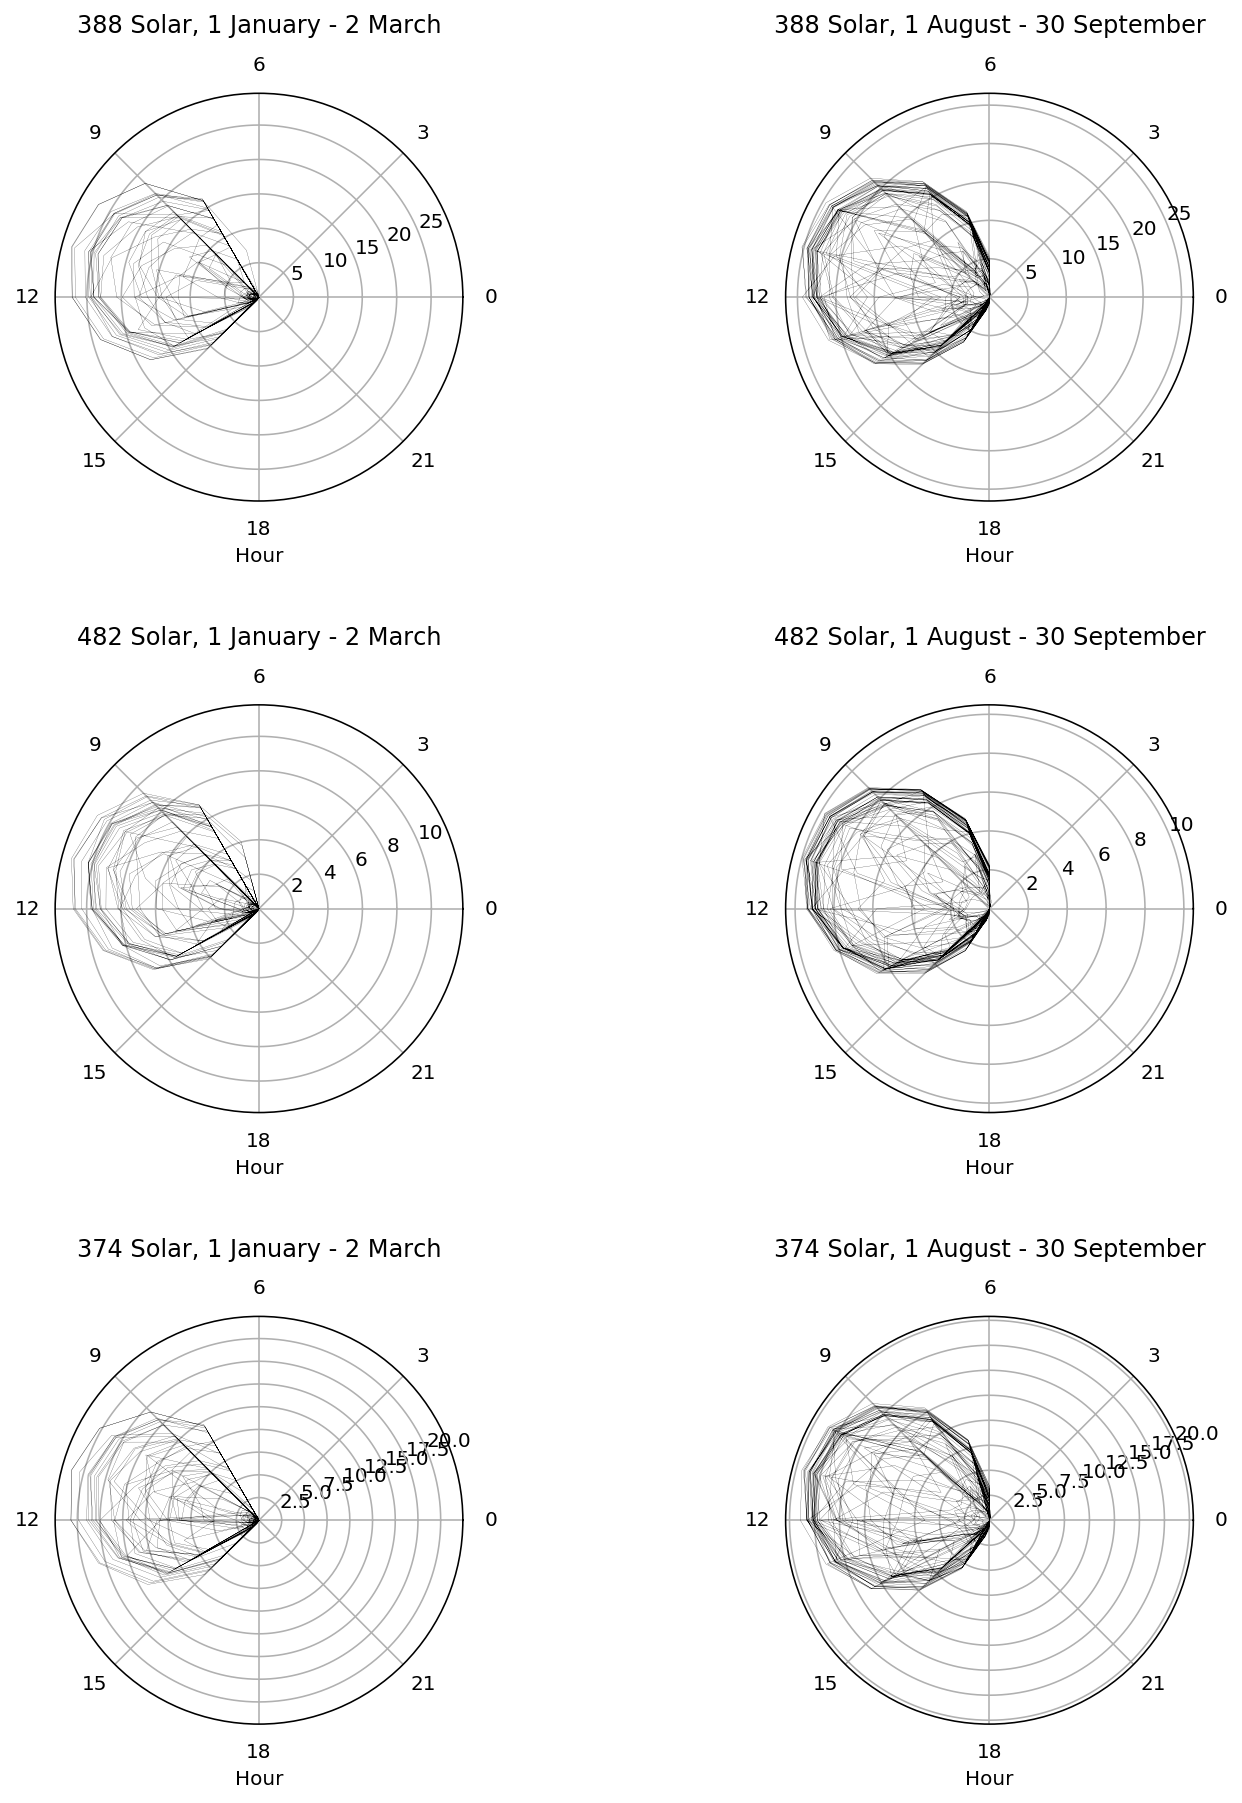

In [11]:
polar_proj = True

solar_generation = network.generators_t.p_max_pu.loc[:,saturation_per_gen.carrier == 'Solar'] * gen_capacity.loc[saturation_per_gen.carrier == 'Solar']

fig = plt.figure(figsize=(12,15))

solar_selection = np.random.choice(solar_generation.columns, size=3)

for i,(gen_name,first_day) in enumerate(itertools.product(solar_selection,[0, (2+7*30)*24])):
    if polar_proj:
        ax = plt.subplot(3,2,i+1,projection='polar')
    else:
        ax = plt.subplot(3,2,i+1)
    #ax = plt.subplot(1,1,1, projection='polar')
    
    gen_series = solar_generation[gen_name]
    #print(x.index.hour)
    x = gen_series.index.hour
    y = gen_series.values
    if polar_proj:
        x *= 2 * np.pi / 24
    
    last_day = first_day + 2*30*24
    
    plt.plot(x[first_day:last_day], y[first_day:last_day], linewidth=.1, c='0')
    if polar_proj:
        ax.set_xticklabels(list(range(0,24,3)))
    else:
        plt.xlim(5,19)
    
    fdate = lambda d: str(d.day) + " " + d.month_name()
    plt.title("{0}, {1} - {2}".format(gen_name, fdate(gen_series.index[first_day]), fdate(gen_series.index[last_day])), pad=20)
    plt.xlabel("Hour")
    if not polar_proj:
        plt.ylabel("Generation (MW)")

fig.subplots_adjust(hspace=.5)

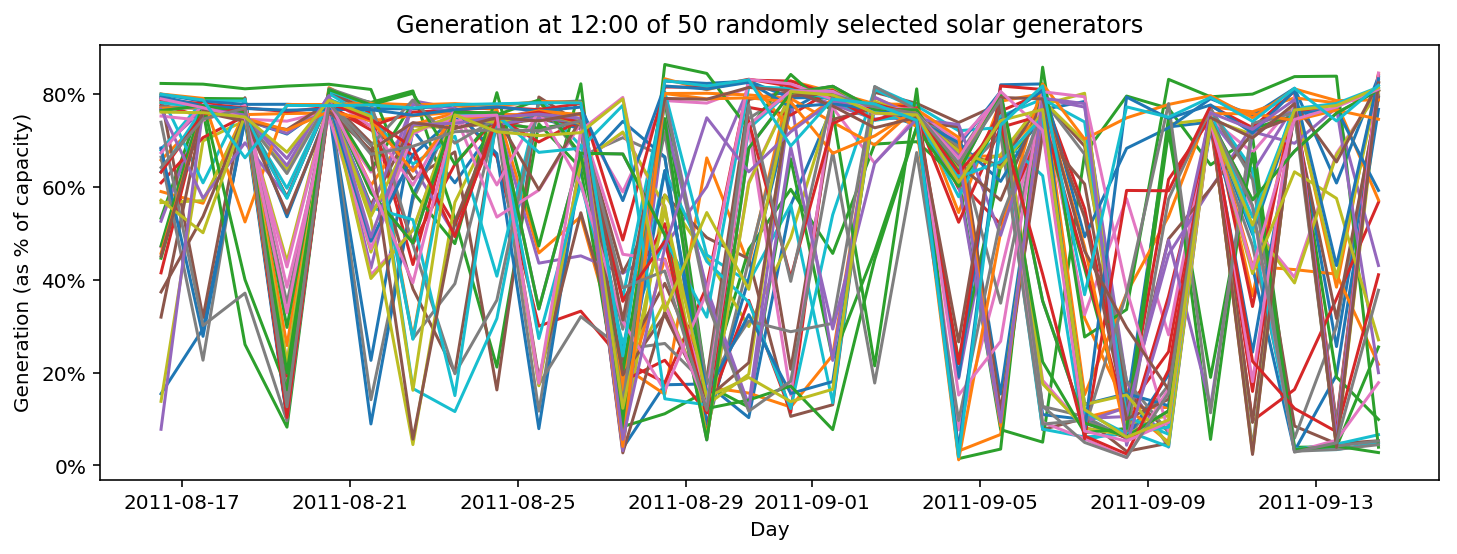

In [30]:
solar_saturation = network.generators_t.p_max_pu.loc[:,saturation_per_gen.carrier == 'Solar']

fig, ax = plt.subplots(figsize=(12,4))

hour = 12
d_start = 2+8*30-15
d_end = d_start+30

times = solar_saturation.index[[12+24*i for i in range(d_start, d_end)]]

plt.title(f"Generation at {hour}:00 of {n_generators} randomly selected solar generators")

n_generators = 50
solar_selection = np.random.choice(solar_saturation.columns, size=n_generators, replace=False)
selected_saturation = solar_saturation[solar_selection].loc[times,:]
for gen_name in selected_saturation:
    plt.plot(times, selected_saturation[gen_name])

plt.xlabel("Day")
plt.ylabel("Generation (as % of capacity)")
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda z, _: '{:.0%}'.format(z)))


## Geographic correlation
Instead of selecting solar generators randomly, let's select all solar generators within a close proximity. We can use a randomly selected generator as a circle centre, and select all generators within a fixed radius.

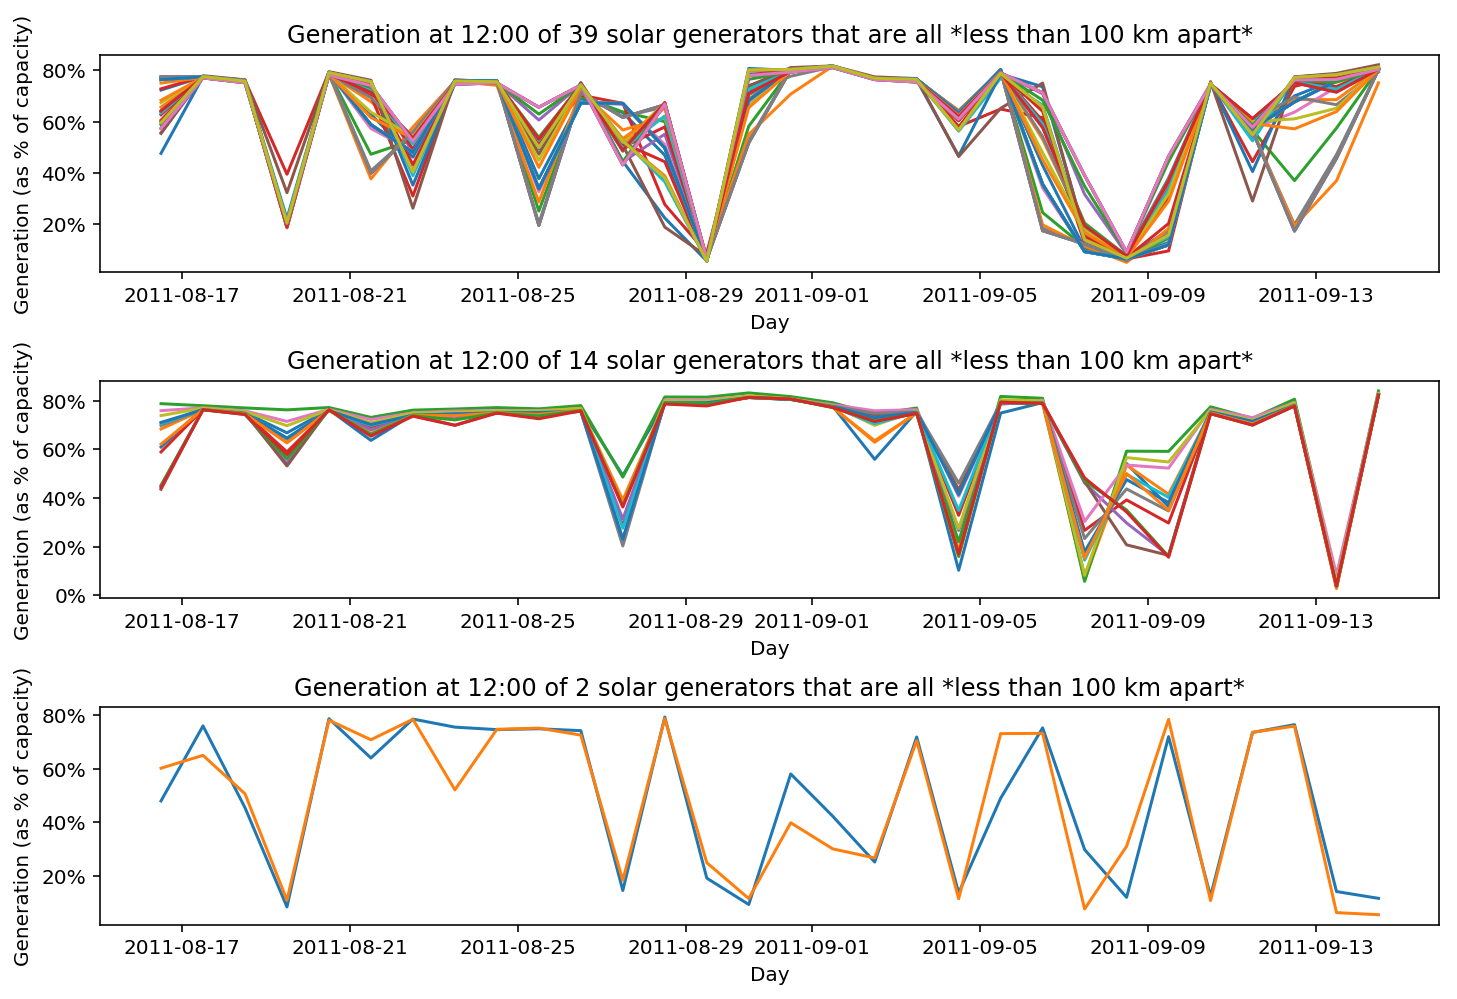

In [34]:
solar_bus_names = network.generators.bus[solar_saturation.columns]
solar_locations = pd.DataFrame(data=network.buses.loc[solar_bus_names.values,:].loc[:,['x','y']].values,index=solar_saturation.columns, columns=['x','y'])

s = lambda z: z*z
dist = lambda a,b: (s(solar_locations.x[a] - solar_locations.x[b])+s(solar_locations.y[a] - solar_locations.y[b]))


dist_lim_km = 50
dist_lim_degree_squared = s(dist_lim_km * np.cos(50 * 180/np.pi) * 360/40000)



fig = plt.figure(figsize=(12,8))

for i in range(3):
    ax = plt.subplot(3,1,i+1)
    
    first_gen = np.random.choice(solar_saturation.columns)
    solar_selection = solar_saturation.loc[:,[dist(a,first_gen) < dist_lim_degree_squared for a in solar_saturation.columns]].columns
    selected_saturation = solar_saturation[solar_selection].loc[times,:]
    
    for gen_name in selected_saturation:
        plt.plot(times, selected_saturation[gen_name])

    plt.title(f"Generation at {hour}:00 of {len(solar_selection)} solar generators that are all *less than {dist_lim_km*2} km apart*")
    plt.xlabel("Day")
    plt.ylabel("Generation (as % of capacity)")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda z, _: '{:.0%}'.format(z)))

fig.subplots_adjust(hspace=.5)